### Joint Blind-Denoising and Cosmological Parameter Inference  (NEED: POWER SPECTRUM GRAPH)

We create a alternating Gibbs Sampling procedure where we infer CMB signal (gaussian-like) parameters akin to noise in natural image denoising + posterior sampler is intersteller dust simulations

**CMB**  
Model temperature fluctuations as  
$$
\mu = 0,\quad \mathrm{Cov}(y) = \Sigma_\phi,
$$  

where  
$$
\Sigma_\phi = \Sigma(H_0,\;\Omega_b,\;\sigma).
$$  
Hubble Constant ~ Uniform-Sampling, Baryon Density ~ Uniform-Sampling, Noise Amplitude


##### Data-Loading + Inspection (LOAD: UNIX-enviornment)

In [1]:
# !pip install astropy camb healpy pixella

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import camb
from camb import model, initialpower
import pixell.enmap as enmap # For flat-sky map operations
from pixell import curvedsky # For generating GRFs from Cls
import healpy as hp # Often used by CAMB for Cls
import warnings
import time
import torch
import torch.nn as nn
import importlib
import cv2

warnings.filterwarnings('ignore')

In [2]:
from modules.utils.metrics import *

In [3]:
# --- Configuration ---
# Map properties
NPIX_SIDE = 256  # Number of pixels on a side
PIX_SIZE_ARCMIN = 8.0  # Pixel size in arcminutes
SHAPE, WCS = enmap.geometry(pos=(0,0), shape=(NPIX_SIDE, NPIX_SIDE), res=np.deg2rad(PIX_SIZE_ARCMIN/60.), proj="car")
# SHAPE will be (NPIX_SIDE, NPIX_SIDE), WCS is the world coordinate system object

# Cosmological Parameters (Fiducial values from paper's footnote 8)
H0_FID = 67.5 # Example, adjust if paper specifies exact CAMB H0
OMBH2_FID = 0.022 # Baryon density omega_b * h^2
OMCH2_FID = 0.122 # Cold dark matter density omega_c * h^2
OMK_FID = 0.0    # Omega_k
TAU_FID = 0.0544 # Optical depth
NS_FID = 0.9649  # Scalar spectral index
AS_FID = 2.1e-9  # Scalar amplitude (ln(10^10 As) = 3.044 => As ~ 2.1e-9)

# Noise parameter Phi = (sigma_cmb, H0_cosmo, ombh2_cosmo)
# Priors (from paper Section 3.2)
H0_PRIOR_MIN, H0_PRIOR_MAX = 50.0, 90.0
OMBH2_PRIOR_MIN, OMBH2_PRIOR_MAX = 0.0075, 0.0567 # Note: paper uses omega_b, CAMB uses ombh2
# To convert: omega_b = ombh2 / (H0/100)^2. For priors, it's easier to sample H0 and ombh2 directly.
SIGMA_CMB_PRIOR_MIN, SIGMA_CMB_PRIOR_MAX = 0.1, 1.2 # sigma_min should be >0. Let's use 0.1 for now.

# Data paths (MODIFY THESE)
DUST_DATA_DIR = "data/cosmo/CATS_dust_data/dens_t750.fits" # Placeholder
OUTPUT_DIR = "data/cosmo/generated_data/"
OUTPUT_DUST_MAP_DIR = "data/cosmo/generated_dust_maps/"

os.makedirs(OUTPUT_DUST_MAP_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "dust_maps"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "cmb_maps"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "mixed_maps"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "params"), exist_ok=True)

NUM_SAMPLES_TO_GENERATE = 10 # Small number for testing

In [4]:
SUB_SHAPE = (12, 12)

Intersteller Dust Simulations (NEED: CATS data (real dust))

In [5]:
def simulate_dust_map(index, output_dir=os.path.join(OUTPUT_DIR, "dust_maps")):
    """
    Placeholder for loading a dust map.
    Replace this with actual loading from CATS database.
    For now, generates a synthetic "dust-like" map.
    """
    
    # --- BEGIN PLACHOLDER ---
    # Try to load if it exists (e.g., if you pre-process CATS)
    # filepath = os.path.join(DUST_DATA_DIR, f"dust_map_{index:04d}.npy")
    # if os.path.exists(filepath):
    #     return enmap.read_map(filepath) # Assuming maps are saved as .npy or FITS

    # Generate synthetic dust: power-law power spectrum
    ells = np.fft.fftfreq(NPIX_SIDE, d=np.deg2rad(PIX_SIZE_ARCMIN / 60.0)) * 2 * np.pi
    ell_grid_x, ell_grid_y = np.meshgrid(ells, ells)
    ell_mod = np.sqrt(ell_grid_x**2 + ell_grid_y**2)
    
    # Power law: P(k) ~ k^-alpha. Let's use alpha around 2.5-3 for dust-like structures
    alpha_dust = 2.7
    ps2d_dust = np.zeros_like(ell_mod)
    ps2d_dust[ell_mod > 0] = ell_mod[ell_mod > 0]**(-alpha_dust)
    ps2d_dust[0, 0] = 0 # No DC component in fluctuations

    # Generate random phases
    random_phases = np.exp(1j * 2 * np.pi * np.random.rand(NPIX_SIDE, NPIX_SIDE))
    
    # Create map in Fourier space
    map_fourier = np.sqrt(ps2d_dust) * random_phases
    
    # Inverse FFT to get real-space map
    dust_map_data = np.fft.ifft2(map_fourier).real
    
    # Normalize to have some reasonable range (e.g., mean 0, std 1, then scale)
    dust_map_data = (dust_map_data - np.mean(dust_map_data)) / np.std(dust_map_data)
    dust_map_data *= 50 # Arbitrary scaling for visual purposes
    
    dust_map = enmap.ndmap(dust_map_data, WCS)
    # --- END PLACEHOLDER ---

    # Save the generated/loaded map (optional, good for consistency)
    # enmap.write_map(os.path.join(output_dir, f"dust_{index:04d}.fits"), dust_map)
    dust_map = cv2.resize(dust_map, SUB_SHAPE)
    
    return dust_map

Testing dust map generation/loading...


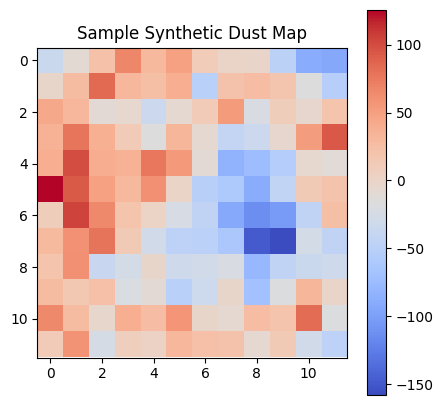

In [6]:
print("Testing dust map generation/loading...")
test_dust = simulate_dust_map(0)
plt.figure(figsize=(5,5))
plt.imshow(test_dust, cmap='coolwarm')
plt.title("Sample Synthetic Dust Map")
plt.colorbar()
# plt.savefig(os.path.join(OUTPUT_DIR,"sample_synthetic_dust.png"))
plt.show()
# print("Synthetic dust map generated and saved.")

CATS - Dataset

In [7]:
from astropy.io import fits # Example for FITS files
import os

https://www.mhdturbulence.com/

Cho-ENO - Mach ~ 7

In [8]:
SIMULATION_DICT = {
    "data/cosmo/CATS_dust_data/dens_t750.fits": {
        "run_id": "b.1p.01", 
        "timesteps": "t_750"
    }
}

TARGET_MAP_SIZE = (NPIX_SIDE, NPIX_SIDE)

In [9]:
def create_column_density_map_from_cube(density_cube_3d, axis=0):
    """
    Creates a 2D column density map by integrating along a specified axis.
    """
    if density_cube_3d.ndim != 3: # Basic check
        raise ValueError(f"Input must be a 3D density cube. Got {density_cube_3d.ndim} dimensions.")
    # Shape check will be done before calling or after augmentation
    return np.sum(density_cube_3d, axis=axis)

def augment_3d_cube(cube):
    """
    Applies random augmentations (rotations, flips) to a 3D cube.
    Returns the augmented cube.
    """
    augmented_cube = cube.copy()

    # 1. Random Flips (along each axis with 50% probability)
    if np.random.rand() > 0.5:
        augmented_cube = np.flip(augmented_cube, axis=0)
    if np.random.rand() > 0.5:
        augmented_cube = np.flip(augmented_cube, axis=1)
    if np.random.rand() > 0.5:
        augmented_cube = np.flip(augmented_cube, axis=2)

    # 2. Random Rotations (90-degree increments around random axis)
    # More complex rotations are possible but add complexity with non-cubic results
    # and interpolation. For now, stick to 90-degree rotations which preserve grid.
    num_rotations = np.random.randint(0, 4) # 0, 1, 2, or 3 ninety-degree rotations
    rot_axis_idx = np.random.randint(0, 3)  # 0 for x, 1 for y, 2 for z (axes to rotate around)
    
    axes_to_rotate = [(1,2), (0,2), (0,1)][rot_axis_idx] # (axes[0], axes[1]) for rotate function

    if num_rotations > 0:
        # Scipy.ndimage.rotate uses degrees.
        # Note: scipy.ndimage.rotate can change array shape if not careful,
        # and introduces interpolation. For exact 90-deg rotations without shape change
        # or interpolation, np.rot90 is better.
        augmented_cube = np.rot90(augmented_cube, k=num_rotations, axes=axes_to_rotate)
        
    return augmented_cube


In [10]:
def generate_single_dust_map(verbose=False):
    """
    Generates a single, randomly augmented 2D dust column density map.
    It randomly selects a 3D cube from the pre-scanned paths,
    applies random augmentations, and integrates along a random axis.

    Returns:
        np.ndarray: A 2D dust map, or None if no source cubes are available or an error occurs.
    """

    try:
        # 1. Randomly select a 3D density cube path
        cube_path = np.random.choice(list(SIMULATION_DICT.keys()))
        if verbose: print(f"Selected cube: {cube_path}")

        # 2. Load the 3D density cube
        with fits.open(cube_path) as hdul:
            density_cube_3d = hdul[0].data
        
        if density_cube_3d.shape != (NPIX_SIDE, NPIX_SIDE, NPIX_SIDE):
            if verbose: print(f"Warning: Cube {cube_path} has unexpected shape {density_cube_3d.shape}. Skipping.")
            return None # Or retry with another cube

        # 3. Apply random 3D augmentations
        augmented_cube = augment_3d_cube(density_cube_3d)

        # 4. Randomly select an integration axis
        integration_axis = np.random.randint(0, 3) # 0, 1, or 2
        
        # 5. Create column density map
        col_dens_map = create_column_density_map_from_cube(augmented_cube, axis=integration_axis)
        
        if col_dens_map.shape != TARGET_MAP_SIZE:
             if verbose: print(f"Warning: Generated map has shape {col_dens_map.shape}, expected {TARGET_MAP_SIZE}. This might indicate an issue in augmentation or projection.")
             # Potentially add cropping/resizing here if augmentations can change shape,
             # but np.rot90 with 90-deg steps on cubic arrays should preserve shape.
             return None
        col_dens_map = cv2.resize(col_dens_map, SUB_SHAPE)
        return col_dens_map

    except Exception as e:
        if verbose: print(f"Error generating single dust map from {cube_path if 'cube_path' in locals() else 'N/A'}: {e}")
        return None

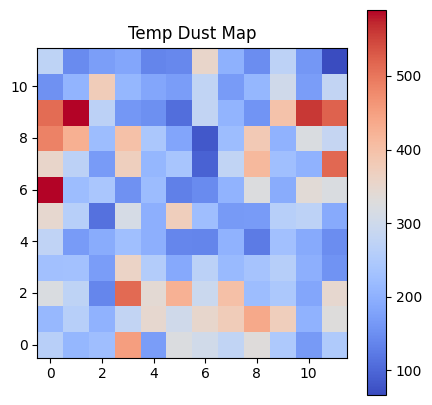

In [11]:
temp_dust_map = generate_single_dust_map()

plt.figure(figsize=(5, 5))
plt.imshow(temp_dust_map, origin='lower', cmap='coolwarm', vmax=np.percentile(temp_dust_map, 99))
plt.title("Temp Dust Map")
plt.colorbar()
plt.show()

CMB simulation

In [12]:
def get_camb_cls(H0, ombh2, omch2=OMCH2_FID, omk=OMK_FID, tau=TAU_FID,
                 As=AS_FID, ns=NS_FID, lmax=3*NPIX_SIDE): # lmax somewhat larger than Nyquist
    """
    Uses CAMB to calculate TT power spectra.
    """
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=H0, ombh2=ombh2, omch2=omch2, omk=omk, tau=tau)
    pars.InitPower.set_params(As=As, ns=ns, r=0) # r=0 for no tensors
    pars.set_for_lmax(lmax, lens_potential_accuracy=0) # lens_potential_accuracy=0 if not lensing

    results = camb.get_results(pars)
    powers = results.get_cmb_power_spectra(pars, CMB_unit='muK') # Get Cls in uK^2
    cl_tt = powers['total'][:, 0] # TT spectrum (0-indexed for l, so cl_tt[l] is C_l^TT)
    
    # CAMB returns Cls from l=0. We need l=0 to lmax.
    # Ensure cl_tt has length lmax+1. CAMB might return up to lmax_calc.
    if len(cl_tt) > lmax + 1:
        cl_tt = cl_tt[:lmax+1]
    elif len(cl_tt) < lmax + 1:
        # Pad with zeros if CAMB didn't compute up to lmax (shouldn't happen with set_for_lmax)
        cl_tt = np.pad(cl_tt, (0, lmax + 1 - len(cl_tt)), 'constant')

    # Remove monopole and dipole from Cls for map generation (often done)
    cl_tt[0] = 0 
    cl_tt[1] = 0
    return cl_tt # Units of uK^2

def generate_cmb_map(cl_tt, sigma_cmb_amp, seed=None):
    """
    Generates a flat-sky CMB map realization from Cls using pixell.
    cl_tt should be the power spectrum D_l = l(l+1)C_l/2pi or C_l.
    pixell.curvedsky.rand_map expects C_l.
    sigma_cmb_amp is the overall amplitude scaling factor mentioned in paper (Phi).
    """
    # The Cls from CAMB are C_l.
    # The sigma_cmb_amp from the paper seems to be a direct multiplier on the *covariance*,
    # so it's a multiplier on Cls (power), or on the map std. dev. if it's sqrt(power).
    # Let's assume sigma_cmb_amp scales the *standard deviation* of the CMB map.
    # So, C_l_scaled = (sigma_cmb_amp^2) * C_l_fiducial
    # However, the paper describes sigma as part of Phi, which parametrizes Sigma_Phi.
    # If Sigma_Phi = sigma^2 * Sigma_phi_base, then C_l_effective = sigma^2 * C_l_base
    
    scaled_cl_tt = cl_tt * (sigma_cmb_amp**2) # Scale power spectrum

    # pixell.curvedsky.rand_map needs an array of Cls [TT, EE, BB, TE, ...]
    # For TT only:
    cls_for_randmap = np.zeros((1, len(scaled_cl_tt))) # Shape (1, nl) for just T
    cls_for_randmap[0, :] = scaled_cl_tt
    
    cmb_map_data = curvedsky.rand_map(SHAPE, WCS, cls_for_randmap, seed=seed)
    cmb_map_data = enmap.ndmap(cmb_map_data, WCS) # Returns a single map (T)
    cmb_map_data = cv2.resize(cmb_map_data, SUB_SHAPE)

    return cmb_map_data


Testing CMB map generation...


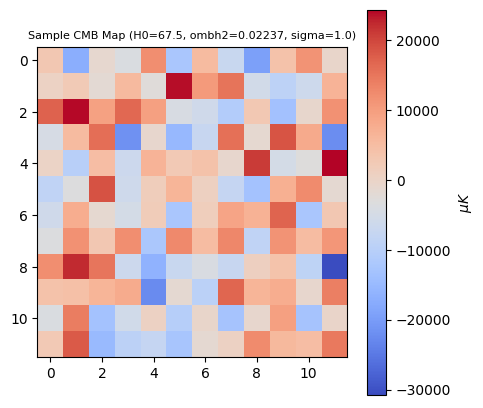

In [13]:
# Test CMB generation
print("\nTesting CMB map generation...")
fiducial_H0 = 67.5
fiducial_ombh2 = 0.02237 # Example value
fiducial_sigma_cmb = 1.0 

test_cls_tt = get_camb_cls(H0=fiducial_H0, ombh2=fiducial_ombh2)
test_cmb = generate_cmb_map(test_cls_tt, sigma_cmb_amp=fiducial_sigma_cmb, seed=42)

plt.figure(figsize=(5,5))
plt.imshow(test_cmb, cmap='coolwarm')
plt.title(f"Sample CMB Map (H0={fiducial_H0}, ombh2={fiducial_ombh2}, sigma={fiducial_sigma_cmb})", fontsize=8)
plt.colorbar(label="$\mu K$")
plt.show()

Data-Generation (Mixed)

In [15]:
def generate_dataset_sample(index, seed_offset=0, verbose=False):
    """Generates one sample: dust_map, cmb_map, mixed_map, and cmb_params."""
    current_seed_dust = index + seed_offset 
    current_seed_cmb = index + seed_offset + NUM_SAMPLES_TO_GENERATE # ensure different seeds

    # 1. Get Dust map
    # dust_map = generate_dust_map(index) # Use index for dust map selection if you have a list
    dust_map = generate_single_dust_map() 

    # 2. Sample CMB parameters from prior
    h0_sample = np.random.uniform(H0_PRIOR_MIN, H0_PRIOR_MAX)
    ombh2_sample = np.random.uniform(OMBH2_PRIOR_MIN, OMBH2_PRIOR_MAX)
    sigma_cmb_sample = np.random.uniform(SIGMA_CMB_PRIOR_MIN, SIGMA_CMB_PRIOR_MAX)
    
    cmb_params = {
        'H0': h0_sample,
        'ombh2': ombh2_sample,
        'sigma_cmb': sigma_cmb_sample
    }

    # 3. Generate CMB map
    cls_tt_sample = get_camb_cls(H0=h0_sample, ombh2=ombh2_sample)
    cmb_map = generate_cmb_map(cls_tt_sample, sigma_cmb_amp=sigma_cmb_sample, seed=current_seed_cmb)

    if verbose:
    # 4. Create mixed map
        print(type(dust_map), dust_map.shape, cmb_map.shape)
        print('Dust-Map: ', min(np.ravel(dust_map)), max(np.ravel(dust_map)))
        print('CMB-Map: ', min(np.ravel(cmb_map)), max(np.ravel(cmb_map)))

    ## z-score norm (standardization)
    dust_map = (dust_map - np.mean(dust_map)) / np.std(dust_map)
    cmb_map = (cmb_map - np.mean(cmb_map)) / np.std(cmb_map)

    if verbose:
        print(type(dust_map), dust_map.shape, cmb_map.shape)
        print('Dust-Map: ', min(np.ravel(dust_map)), max(np.ravel(dust_map)))
        print('CMB-Map: ', min(np.ravel(cmb_map)), max(np.ravel(cmb_map)))

    ## min-max scaling (Norm) ~ [0, 1]/custom descaling
    # dust_map = (dust_map - np.min(dust_map)) / (np.max(dust_map) - np.min(dust_map))
    # cmb_map = (cmb_map - np.min(cmb_map)) / (np.max(cmb_map) - np.min(cmb_map))

    # print(type(dust_map), dust_map.shape, cmb_map.shape)
    # print('Dust-Map: ', min(np.ravel(dust_map)), max(np.ravel(dust_map)))
    # print('CMB-Map: ', min(np.ravel(cmb_map)), max(np.ravel(cmb_map)))

    mixed_map = dust_map + cmb_map
    if verbose:
        print('Mixed-Map: ', min(np.ravel(cmb_map)), max(np.ravel(cmb_map)))
    
    # 5. Save data
    enmap.write_map(os.path.join(OUTPUT_DIR, "dust_maps", f"dust_{index:04d}.fits"), dust_map)
    enmap.write_map(os.path.join(OUTPUT_DIR, "cmb_maps", f"cmb_{index:04d}.fits"), cmb_map)
    enmap.write_map(os.path.join(OUTPUT_DIR, "mixed_maps", f"mixed_{index:04d}.fits"), mixed_map)
    np.save(os.path.join(OUTPUT_DIR, "params", f"params_{index:04d}.npy"), cmb_params)
    # Dust map is saved by load_or_generate_dust_map

    ## (1, 256, 256)
    return np.expand_dims(dust_map, axis=0), np.expand_dims(cmb_map, axis=0), np.expand_dims(mixed_map, axis=0), cmb_params

In [16]:
def generate_mixed_dataset(NUM_SAMPLES_TO_GENERATE, verbose=False):
    print(f"\nGenerating {NUM_SAMPLES_TO_GENERATE} dataset samples...")
    dust_maps, cmb_maps, mixed_maps, params_list = [], [], [], []
    for i in range(NUM_SAMPLES_TO_GENERATE):
        if verbose:
            print(f"Generating sample {i+1}/{NUM_SAMPLES_TO_GENERATE}")
        d_map, c_map, m_map, params = generate_dataset_sample(i)
        
        dust_maps.append(d_map) 
        cmb_maps.append(c_map) 
        mixed_maps.append(m_map)
        params_list.append(params)
    
    print("Dataset generation complete.")
    return np.array(dust_maps), np.array(cmb_maps), np.array(mixed_maps), np.array(params_list) 

In [17]:
## We test with few samples first
NUM_SAMPLES_TO_GENERATE = 8
ft = time.time()
dust_maps, cmb_maps, mixed_maps, params_list = generate_mixed_dataset(NUM_SAMPLES_TO_GENERATE)
lt = time.time()
print('time-taken (mixed-map-generation): ', (lt - ft)/60, ' mins')
print(dust_maps.shape, cmb_maps.shape, mixed_maps.shape, params_list.shape)


Generating 8 dataset samples...
Dataset generation complete.
time-taken (mixed-map-generation):  0.7222061435381572  mins
(8, 1, 12, 12) (8, 1, 12, 12) (8, 1, 12, 12) (8,)


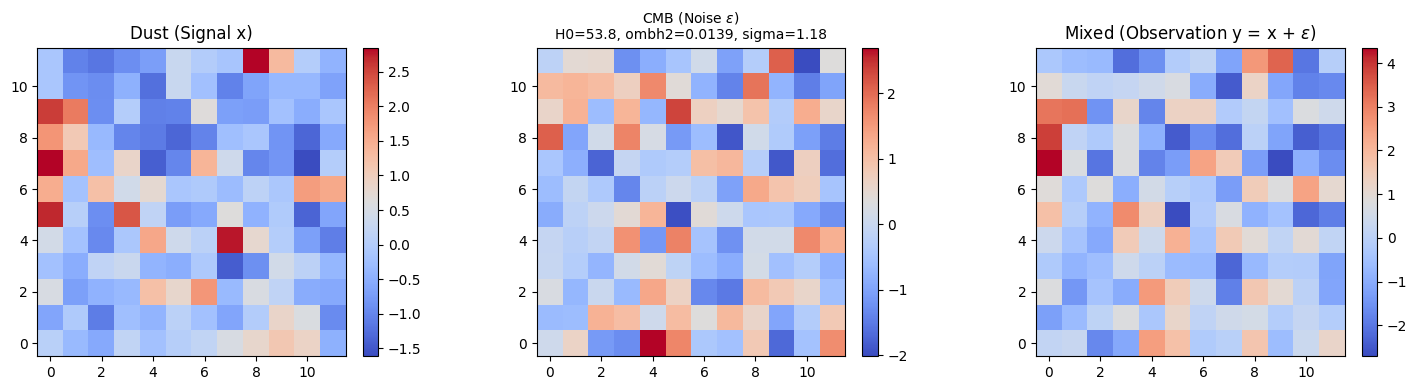

In [19]:
# --- VI. Visualization of a Generated Sample ---
if NUM_SAMPLES_TO_GENERATE > 0:
    sample_idx_to_viz = 0
    data_viz_dust, data_viz_cmb, data_viz_mixed = dust_maps[sample_idx_to_viz], cmb_maps[sample_idx_to_viz], mixed_maps[sample_idx_to_viz]
    params_viz = params_list[sample_idx_to_viz]

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    im0 = axes[0].imshow(np.squeeze(data_viz_dust), cmap='coolwarm', origin='lower', vmax=np.percentile(data_viz_dust, 99))
    axes[0].set_title("Dust (Signal x)")
    fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

    im1 = axes[1].imshow(np.squeeze(data_viz_cmb), cmap='coolwarm', origin='lower')#, vmax=np.percentile(data_viz_cmb, 99))
    axes[1].set_title(f"CMB (Noise $\epsilon$)\nH0={params_viz['H0']:.1f}, ombh2={params_viz['ombh2']:.4f}, sigma={params_viz['sigma_cmb']:.2f}", fontsize=10)
    fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    im2 = axes[2].imshow(np.squeeze(data_viz_mixed), cmap='coolwarm', origin='lower')#, vmax=np.percentile(data_viz_mixed, 99))
    axes[2].set_title("Mixed (Observation y = x + $\epsilon$)")
    fig.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)

    plt.tight_layout()
    # plt.savefig(os.path.join(OUTPUT_DIR, f"visualization_sample_{sample_idx_to_viz:04d}.png"))
    plt.show()
    # plt.close()

In [20]:
signal = torch.tensor(dust_maps)
noise = torch.tensor(cmb_maps) 
observation = torch.tensor(mixed_maps)

print(signal.shape, noise.shape, observation.shape)

torch.Size([8, 1, 12, 12]) torch.Size([8, 1, 12, 12]) torch.Size([8, 1, 12, 12])


In [21]:
train_split = 0.75
val_split = 0.2
test_spli = 0.05

In [22]:
indices = np.random.permutation(len(signal))
signal_shuffled = signal[indices]

# Compute split sizes
n_total = len(signal)
n_train = int(train_split * n_total)
n_val = int(val_split * n_total)
n_test = n_total - n_train - n_val  # ensure it sums to total

# Split the data
signal_shuffled_train = signal_shuffled[:n_train]
signal_shuffled_val = signal_shuffled[n_train:n_train + n_val]
signal_shuffled_test = signal_shuffled[n_train + n_val:]

# Convert to PyTorch tensors
signal_train = torch.tensor(signal_shuffled_train, dtype=torch.float32)
signal_val = torch.tensor(signal_shuffled_val, dtype=torch.float32)
signal_test = torch.tensor(signal_shuffled_test, dtype=torch.float32)

print(signal_train.shape, signal_val.shape, signal_test.shape)

torch.Size([6, 1, 12, 12]) torch.Size([1, 1, 12, 12]) torch.Size([1, 1, 12, 12])


#### Training 

In [264]:
input_size = SUB_SHAPE

In [265]:
import modules.comp.two_d.unet_2d_cosmo
importlib.reload(modules.comp.two_d.unet_2d_cosmo)
from modules.comp.two_d.unet_2d_cosmo import Unet2DGDiff_cosmo

In [266]:
gmodel_2d_cosmo = Unet2DGDiff_cosmo(
    dim = 4,
    channels=1
)

## time-embedding shape -> t = torch.randint(0, self.num_timesteps, (b,), device=device).long() --> (b, )
t_shape = (2, )
x_shape = (2, 1, *input_size)

print(x_shape, t_shape)

print('- UNET-summary -')
gmodel_2d_cosmo.summary(x_shape=x_shape, t_shape=t_shape)

(2, 1, 12, 12) (2,)
- UNET-summary -
____________________________________________________________________________________________________
Model: Unet1D
Layer (type)                            Output Shape             Param #        
input_1 (InputLayer)                    (2, 1, 12, 12)           0              
input_2 (InputLayer)                    (2,)                     0              
init_conv.proj (Conv2d)                 (2, 4, 12, 12)           40             
init_conv.norm (GroupNorm)              (2, 4, 12, 12)           8              
init_conv.act (SiLU)                    (2, 4, 12, 12)           0              
init_conv.dropout (Dropout2d)           (2, 4, 12, 12)           0              
down_blocks.0.block1.proj (Conv2d)      (2, 8, 12, 12)           296            
down_blocks.0.block1.norm (GroupNorm)   (2, 8, 12, 12)           16             
down_blocks.0.block1.act (SiLU)         (2, 8, 12, 12)           0              
down_blocks.0.block1.dropout (Dropout2

In [267]:
import modules.comp.two_d.diffusion_2d_cosmo
importlib.reload(modules.comp.two_d.diffusion_2d_cosmo)
from modules.comp.two_d.diffusion_2d_cosmo import GibbsDiff2D_cosmo

In [268]:
### Just the diffusion framework
gdiffusion_2d_cosmo = GibbsDiff2D_cosmo(
    gmodel_2d_cosmo,
    image_size = (1, *input_size)
)

In [269]:
import modules.comp.diff_trainer
importlib.reload(modules.comp.diff_trainer)
from modules.comp.diff_trainer import TrainerGDiff

In [270]:
train_num_steps = 2

In [166]:
gtrainer = TrainerGDiff(
    gdiffusion_2d_cosmo,
    signal_train,
    signal_val[:50],
    train_batch_size = 8,
    train_lr = 1e-5,
    train_num_steps = train_num_steps, # total training steps
    gradient_accumulate_every = 2,     # gradient accumulation steps
    ema_decay = 0.995,                 # exponential moving average decay
    mode = '2D'
)

ft = time.time()
train_loss_curve, val_loss_curve = gtrainer.train()
lt = time.time()

print('time-taken: ', (lt - ft)/60)

Optimization Steps:   0%|          | 0/2 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [228]:
fig = plt.Figure(figsize=(7, 7))

rate = 10
plt.plot(np.arange(train_num_steps // rate), train_loss_curve[::rate], color = 'red', label = 'train')
plt.plot(np.arange(train_num_steps // rate), val_loss_curve[::rate], color = 'blue', label = 'validation')

plt.ylabel('Loss')
plt.xlabel('#Optimization Steps (sub-sampled)')
plt.title('Loss-Curve (Sub-Sampled)')

plt.grid()
plt.legend()
plt.show()

NameError: name 'train_loss_curve' is not defined

#### Blind-Denoising

In [111]:
from pprint import pprint

this approach will lead to overfit - because I have not split the corres. observation -> signal

omega_b = ombh2 / (H0/100)^2 ## paper uses omega_b

In [81]:
init_sigma = 0.4
main_device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [71]:
y, x0, true_params = observation[-1].view(1, 1, *input_size), signal[-1].view(1, 1, *input_size), params_list[-1]

print(x0.shape, y.shape)
print()
print('True-Params')
print()
pprint(true_params)
true_H0, true_omb, true_sigma = true_params['H0'], true_params['ombh2'], true_params['sigma_cmb']

torch.Size([1, 1, 12, 12]) torch.Size([1, 1, 12, 12])

True-Params

{'H0': 88.77049266397538,
 'ombh2': 0.029302674919595262,
 'sigma_cmb': 0.3231568495815741}


the noising process is continous but the time-step matching/t-indexing procedur is discrete -> so statistical uncertainty remains

In [272]:
sigma_timestep = gdiffusion_2d_cosmo.get_closest_ddpm_timestep_from_sigma_cmb(torch.tensor([init_sigma]).to(main_device))
print('closest_discrete_timestep: ', sigma_timestep)

### t-indexed normalization
alpha_bar_t = gdiffusion_2d_cosmo.alpha_bar_t_ddpm[sigma_timestep].reshape(-1, 1, 1, 1).to(main_device)
yt = torch.sqrt(alpha_bar_t) * y 

print(y.shape, yt.shape)

closest_discrete_timestep:  tensor([117])
torch.Size([1, 1, 12, 12]) torch.Size([1, 1, 12, 12])


might not need y_t (t-indexed-val) as we are uniformly sampling a initial-value ~ U(min > 0, 1.2)

In [273]:
import modules.utils.hmc_cosmo
importlib.reload(modules.utils.hmc_cosmo)
from modules.utils.hmc_cosmo import *

point-estimate

In [274]:
print('x_0_hat (Point-Estimate):')

## x_0_hat, phi_hat -- point estimate - single chain run

ft = time.time()
## version_1 : HMC - sampler is has fixed identity mass_matrix   
phi_sampled, x_denoised = gdiffusion_2d_cosmo.run_gibbs_sampler(y, num_chains_per_gibbs_sample=1, n_it_gibbs=5, n_it_burnin_gibbs=2) 
print('Sampling-Done!')
print(phi_sampled.shape, x_denoised.shape)
print('phi_hat: ', phi_sampled)
lt = time.time()
print('sampling-time-taken: ', (lt - ft)/60, ' mins')

x_0_hat (Point-Estimate):


Gibbs Iterations: 100%|██████████| 7/7 [01:13<00:00, 10.55s/it]

Sampling-Done!
torch.Size([1, 3]) torch.Size([1, 1, 12, 12])
phi_hat:  tensor([[4.6387e-01, 6.5860e+01, 1.8112e-02]])
sampling-time-taken:  1.2309051156044006  mins


posterior-distribution

In [275]:
## x_0_hat, phi_hat -- point estimate - single chain run

print('x_0_hat (Posterior-Distribution):')

ft = time.time()
## n_it_gibbs = chain_length | shape ~ (#chains (post_samples = different chain realisation), batch_size, last_few_states (avg_pmean), *rem-dim)
phi_all_posterior, x_denoised_posterior = gdiffusion_2d_cosmo.blind_posterior_mean(y, num_chains_per_gibbs_sample=5, n_it_gibbs=2, n_it_burnin_gibbs=1, avg_pmean=1, return_full_posterior_chains=True)

phi_all_posterior = phi_all_posterior.mean(dim=2)
x_denoised_posterior = x_denoised_posterior.mean(dim=2)

print('phi_all_posterior: ', phi_all_posterior.shape)
print('x_denoised_posterior: ', x_denoised_posterior.shape)
lt = time.time()
print('sampling-time-taken: ', (lt - ft)/60, ' mins')

x_0_hat (Posterior-Distribution):


Gibbs Iterations: 100%|██████████| 3/3 [01:53<00:00, 37.86s/it]

phi_all_posterior:  torch.Size([5, 1, 3])
x_denoised_posterior:  torch.Size([5, 1, 1, 12, 12])
sampling-time-taken:  1.8932533582051596  mins


Display (NEED: Cornerplot)

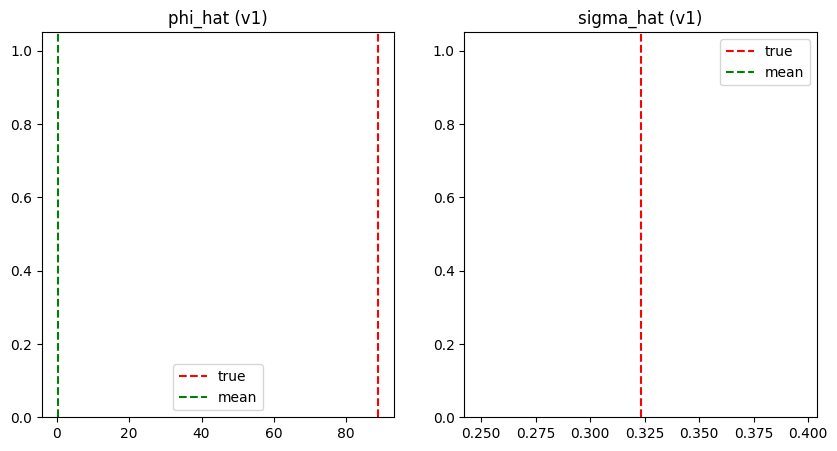

In [276]:
idx = 0

phi_hat = phi_all_posterior[:, idx, 0]
sigma_hat = phi_all_posterior[:, idx, 1]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].hist(phi_hat, bins = 20)
axs[0].set_title('phi_hat (v1)')
axs[0].axvline(true_H0, color='red', linestyle='--', label='true')
axs[0].axvline(phi_hat.mean(dim=0), color='green', linestyle='--', label='mean')
axs[0].legend()

axs[1].hist(sigma_hat, bins = 20)
axs[1].set_title('sigma_hat (v1)')
axs[1].axvline(true_sigma, color='red', linestyle='--', label='true')
axs[1].axvline(sigma_hat.mean(dim=0), color='green', linestyle='--', label='mean')
axs[1].set_xlim(true_sigma - 0.25 * true_sigma, true_sigma + 0.25 * true_sigma)
axs[1].legend()

plt.show()

In [277]:
x_denoised = x_denoised.cpu().numpy().reshape(x_denoised.shape[0], *input_size, 1).astype('float32')
y = y.cpu().numpy().reshape(y.shape[0], *input_size, 1).astype('float32')
yt = yt.cpu().numpy().reshape(yt.shape[0], *input_size, 1).astype('float32')
x0 = x0.cpu().numpy().reshape(x0.shape[0], *input_size, 1).astype('float32')

Prediction

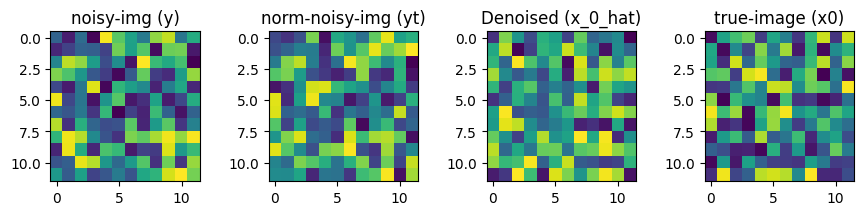

PSNR (clean/denoised):  -3.06783345963989


ValueError: win_size exceeds image extent. Either ensure that your images are at least 7x7; or pass win_size explicitly in the function call, with an odd value less than or equal to the smaller side of your images. If your images are multichannel (with color channels), set channel_axis to the axis number corresponding to the channels.

In [278]:
# x_denoised = x_denoised.numpy()

fig, axs = plt.subplots(1, 4, figsize=(9, 9)) 

axs[2].imshow((x_denoised[0] * 255).astype('uint8'))
axs[2].set_title('Denoised (x_0_hat)')

axs[0].imshow((y[0] * 255).astype('uint8'))
axs[0].set_title('noisy-img (y)')

axs[1].imshow((yt[0] * 255).astype('uint8'))
axs[1].set_title('norm-noisy-img (yt)')

axs[3].imshow((x0[0] * 255).astype('uint8'))
axs[3].set_title('true-image (x0)')

plt.tight_layout(pad=2)
plt.show()

print('PSNR (clean/denoised): ', psnr_2d(x0, x_denoised))
print('SSIM (clean/denoised): ', ssim_2d(x0, x_denoised))
print('L1 (clean/denoised): ', l1_loss_2d(x0, x_denoised))